<a href="https://colab.research.google.com/github/afarley9/perovskites/blob/main/examples/presentation_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team Perovskeet -- Spatial analysis of AIPL images for linear regression**

### by Anne Farley, Evan Chowdhury, Jason Moore, Preetham Paul, and Sam Rae

**Github Repo Link:**  https://github.com/afarley9/perovskites

#Project background
___

Perovskite solar cells, which are solution processed and have efficiencies which rival conventional silicon cells have the potential to be a low-cost, versatile photovoltaic technology.

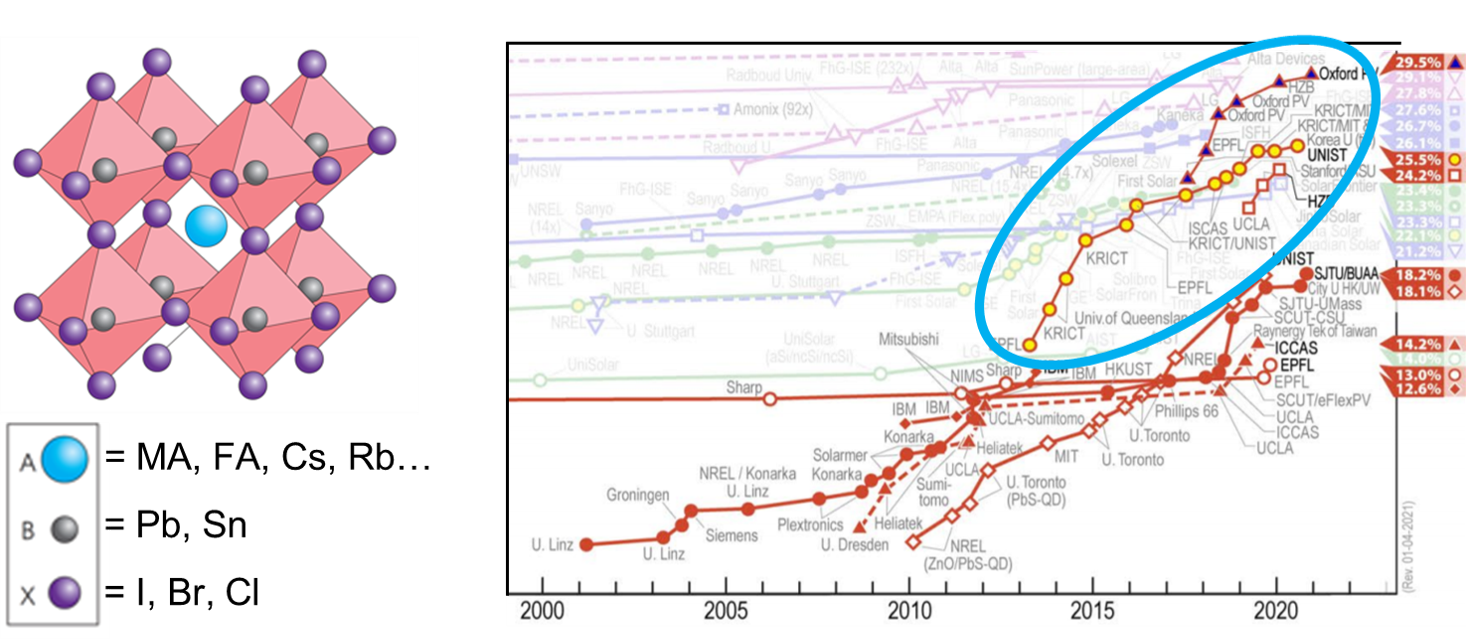

However, the stability of these materials falls far behind silicon, as it is highly susceptible to heat, oxygen, light, and moisture. 

In order to rapidly screen a wide array of compositions we have developed a methodology which collects temporal data on diffusion lenghth, photoluminesence, and transmittance. Using this data we have developed a linear regression based on over 1,000 data points. However, this linear regression is based on PL averages across the film. In this project we sought to incorporate spatial variation.

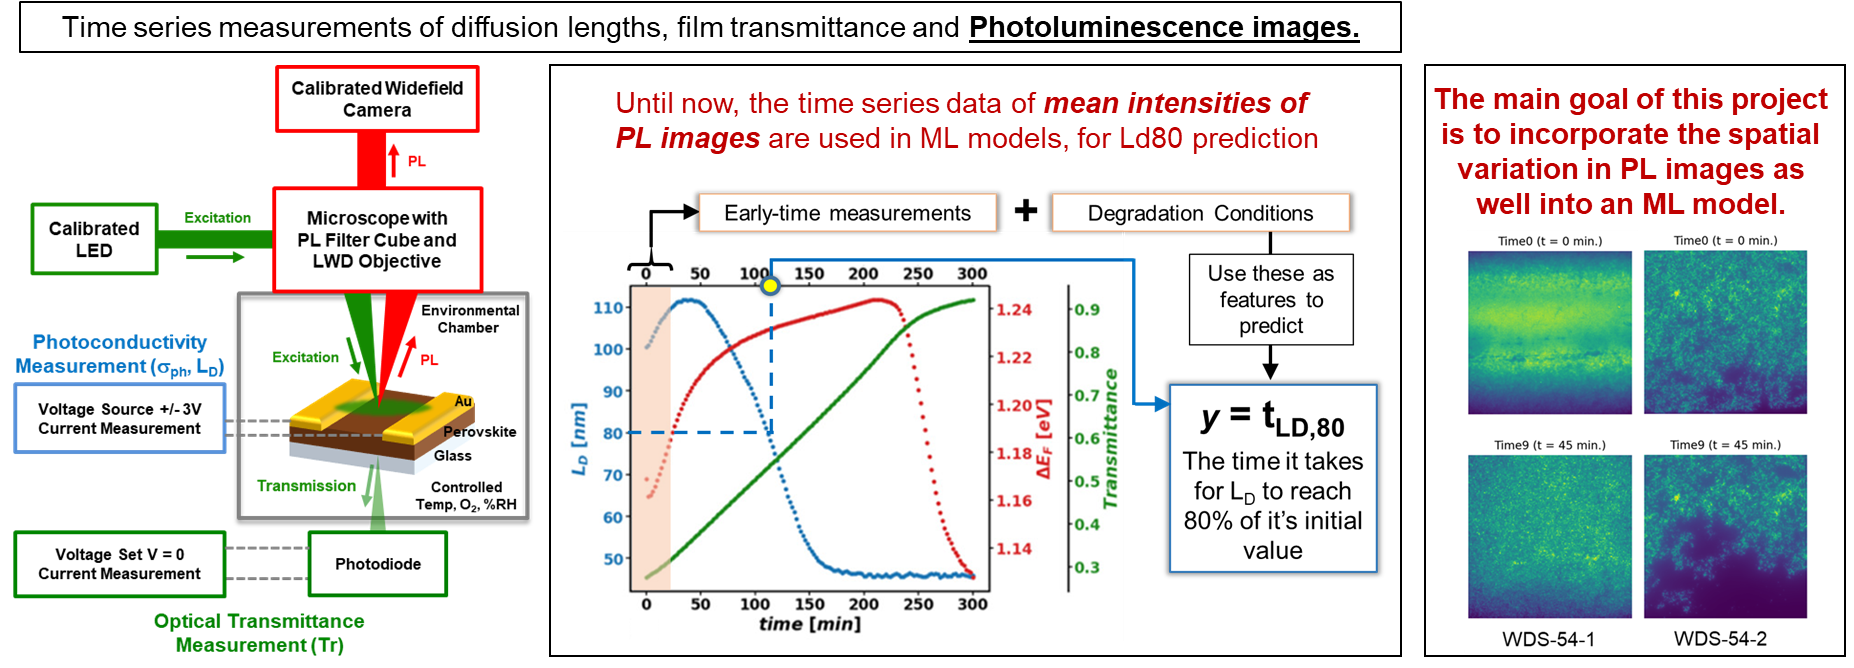

The two methods we used to incorporate this spatial variation include:
* A convolutional neural network to predict $L_{D}^{80}$ solely from images 
* An autoencoder which will dimensionally reduce our images and we will use the encoded layer as a feature in linear regression
  * Additional subpaths in this method include:
    * K-means clustering on the encoded layer
    * PCA on the encoedd layer

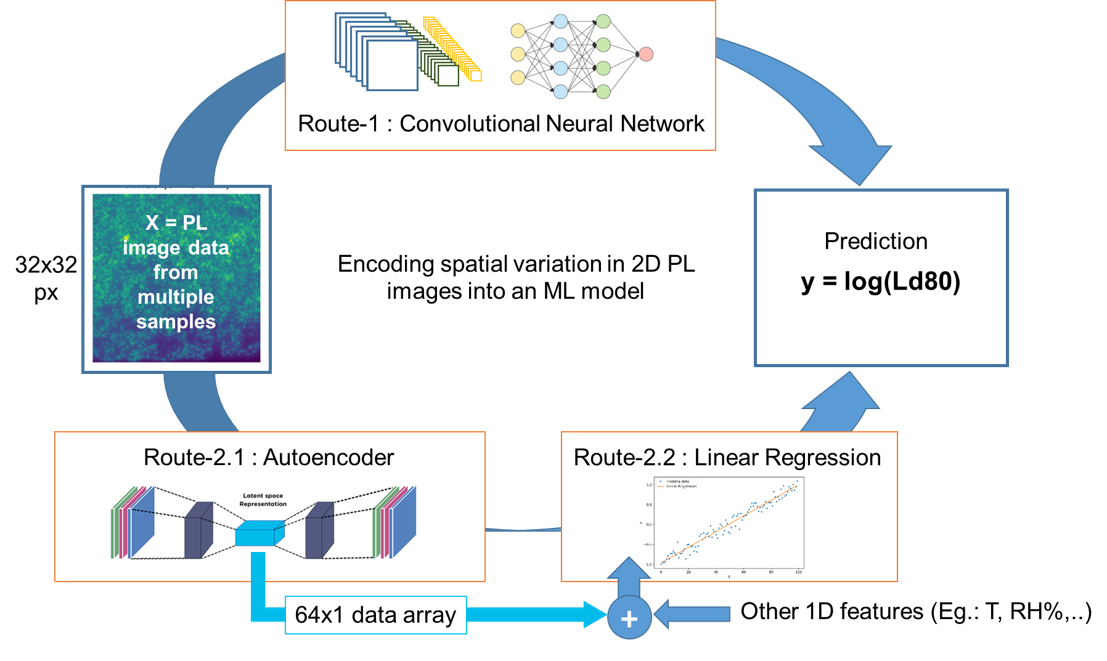

# **Dataset = 1245 Images**

# Demo Setup
___

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import sys
import pickle
import shutil
import json

from keras.models import load_model

# Mount the drive and clone the github repo
drive.mount('/content/drive/')
!git clone https://github.com/afarley9/perovskites.git

# Import modules from the github repo
sys.path.append("/content/perovskites/perovskites")
figure_folder = "/content/perovskites/paper"
import utils.image_processing as impr
import utils.image_loader as loader
import utils.miscellaneous as misc
from utils.autoencoder_to_encoder import autoencoder
from utils.visualize_clusters import visualize_clusters
from utils.visualize_clusters import assign_IDs
import cnn
import linreg
import regression_visualization as reg_vis

Mounted at /content/drive/
Cloning into 'perovskites'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (278/278), done.
remote: Total 1186 (delta 278), reused 231 (delta 126), pack-reused 782
Receiving objects: 100% (1186/1186), 24.00 MiB | 28.48 MiB/s, done.
Resolving deltas: 100% (730/730), done.


### **Creating scope for TPU runtime**
This is the part where we are creating a scope for TPU runtime. We create the model inside the `tpu_strategy.scope` after connecting to a **Google Cloud TPU**.

In [ ]:

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)


Tensorflow version 2.4.1
Running on TPU  ['10.85.254.66:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.85.254.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.85.254.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Route - 1 : Encoding spatial information in PL images via regression using Convolutional Neural Networks
___

The `settings.json` in the perovskites package has all the relevant settings related to the data files and their paths, the model parameters etc, which can be changed by the user and this affects all the models built inside the package.

In [ ]:
with open('/content/perovskites/perovskites/settings.json', 'r') as file:
    model_info = json.load(file)

print(json.dumps(model_info, indent=4))

{
    "target_image_size_um": 50,
    "target_image_size_pix": 32,
    "number_of_clusters": 10,
    "reduced_pca_dims": 10,
    "y_col": "Ld80",
    "FOV_col": "camera_FOV",
    "extract_channel": "true",
    "shared_drive_path": "/content/drive/Shareddrives/Perovskites_DIRECT",
    "data_info": {
        "local_data_folder": "data",
        "pickle_filename": "PL_data.pickle",
        "data_df_filename": "features_intact_filtered.csv",
        "meta_df_filename": "features_meta_filtered.csv"
    },
    "cnn_model_info": {
        "models_folder_path": "models/cnn_saved_models",
        "history_csv_name": "fit_history.csv",
        "model_json_name": "model.json",
        "model_h5_name": "model.h5",
        "fit_json_name": "fit_info.json"
    },
    "linreg_model_info": {
        "models_folder_path": "models/linreg_saved_models",
        "fit_pickle_name": "fit_pickle.pickle"
    }
}


### **Using `image_loader.PLDataLoader()` class to load the dataset**.
All the data can be loaded from the shared google drive using this single class. It has methods for sampling data (`sample()`) and creaing test-train splits (`test_train_split`). The `image_loader` module contains several less frequently used private functions for use if needed.

In [ ]:
dataset = loader.PLDataLoader()
data_tuple = dataset.train_test_split(test_size=0.2,
                                        random_state=42,
                                        shuffle=True,
                                        return_dfs=True)
X_train = data_tuple[0]
X_test = data_tuple[1]
y_train = data_tuple[2]
y_test = data_tuple[3]
meta_df_train = data_tuple[4]
meta_df_test = data_tuple[5]
data_df_train = data_tuple[6]
data_df_test = data_tuple[7]

# Apply log transform
y_train = np.log(y_train)
y_test = np.log(y_test)
y_label = 'log('+model_info['y_col']+')'

All the paths to the relevant images and the corresponding experimental metadata are stored in a master csv file which lists details of **1,245 individual degradation experiments**. So this study is going to be done on a well-documented and experimentally collected dataset. But, the challenge is that since the data is experimentally collected and is prone to human-induced and other irreducible noise, it is required to undergo an extensive data-cleaning process to get reliable results. As used above, the `PLDataLoader()` can be used to load the data and also make the test-train splits. ***Note that the dataset is currently available only to the team members due to confidentiality of the data as most of it is unpublished***.


### **Training and saving a CNN model**

* ***Input*** : PL image data set with shape (N, 32, 32, 1)
* ***Output*** : log(Ld80) prediction values with shape (N,)

We developed a `CNNPredictor()` class that has an optimized keras-based Convolutional Neural Network (CNN) regression model. Check all the methods in the `CNNPredictor()` class.

In [ ]:
#with tpu_strategy.scope():
model_name = 'training_demo'
demo_model = cnn.CNNPredictor(name=model_name, y_label=y_label)
print(demo_model.__doc__)


    This class the following methods for training, testing, modifying the
    CNN model we have built for perovskites PL images to predict the log(Ld80)
    values. It initializes with the model we have built when called.
    1. summary() : Gives summary of model
    2. get_layers_dict() : Returns the model as dictionary
    3. load_layers_from_dict() : Loads the model from a dictionary
    4. save_model() : Saves the model
    5. load_model() : Loads a model
    6. fit() : Fits the training data
    7. evaluate_error() : Evaluates error at X
    8. predict() : Predicts y at given X
    9. full_analysis() : Does fitting, saving and also visualizations
    


In [ ]:
demo_model.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 32)        36896     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 16)          18448     
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                25664     
_________________________________________________________________
dense_5 (Dense)              (None, 32)               

Lets train the model from demonstration using just 5 `epochs` and a `batch_size` of 500

In [ ]:
demo_model.fit(X=X_train, y=y_train, epochs=3, batch_size=500,
               validation_split=0.2)

---------------- CNN Training ----------------
|    Size of train set     |              996 |
|      No. of epochs       |                3 |
|        Batch size        |              500 |
|     Feed image shape     | [996, 32, 32, 1] |
----------------------------------------------


Epoch 1/3
2/2 [==============================] - 2s 676ms/step - loss: 118.1755 - val_loss: 99.9828
Epoch 2/3
2/2 [==============================] - 1s 480ms/step - loss: 99.9787 - val_loss: 99.9552
Epoch 3/3
2/2 [==============================] - 1s 476ms/step - loss: 99.9513 - val_loss: 99.9348



You can also save the trained model using the `saved_model` method as shown below. You have an option to overwrite if another model exists with the same name, or provide an alternative name as you wish (see docs for more details). 

In [ ]:
demo_model.save_model(save_to_drive=True,
                      overwrite_existing_model=True)
saved_models_path = model_info['cnn_model_info']['models_folder_path']
saved_models_path = model_info['shared_drive_path'] + '/' + saved_models_path
curr_model_path = saved_models_path + '/' + model_name

print("In cnn_saved_models folder in the shared drive:")
!ls $saved_models_path
print("\nIn '"+ model_name+"' folder in the cnn_saved_models:")
!ls $curr_model_path

In cnn_saved_models folder in the shared drive:
model_logs_batch10   model_logs_batch200  model_logs_batch25  training_demo
model_logs_batch100  model_logs_batch23   model_logs_batch50

In 'training_demo' folder in the cnn_saved_models:
fit_history.csv  fit_info.json	model.h5  model.json


### **Loading a pre-trained CNN model for improving it further**

You can also load a saved CNN model by using it's `model_name`, which is same as the name of its folder, in the `cnn_saved_models`. Note the class variables when `CNNPredictor` is initialized.

In [ ]:
model = cnn.CNNPredictor(name='demo_model_load', y_label=y_label)
print("Current fit epoch status :", model.epochs)
print("Current fit batch_size :", model.batch_size)
print("Current fit history size :", model.history_df.shape)

Current fit epoch status : 0
Current fit batch_size : 0
Current fit history size : (0, 0)


Now, after loading the model `model_logs_batch25` using the `load_model()` method, note the change in the class variable values.

In [ ]:
#@title Error from CNN
model.load_model('model_logs_batch25', from_drive=True)
print("Current fit epoch status :", model.epochs)
print("Current fit batch_size :", model.batch_size)
print("Current fit history size :", model.history_df.shape)

# Evaluate error from saved weights
print("\nThe error on the test set obtained")
print("from this previously trained model is:")
print(model.evaluate_error(X_test, y_test), '%')

Current fit epoch status : 500
Current fit batch_size : 25
Current fit history size : (500, 3)

The error on the test set obtained
from this previously trained model is:
28.496753692626953 %


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


This scoring metric is not available. Returning the
                  mean absolute percentage error instead...

This scoring metric is not available. Returning the
                  mean absolute percentage error instead...



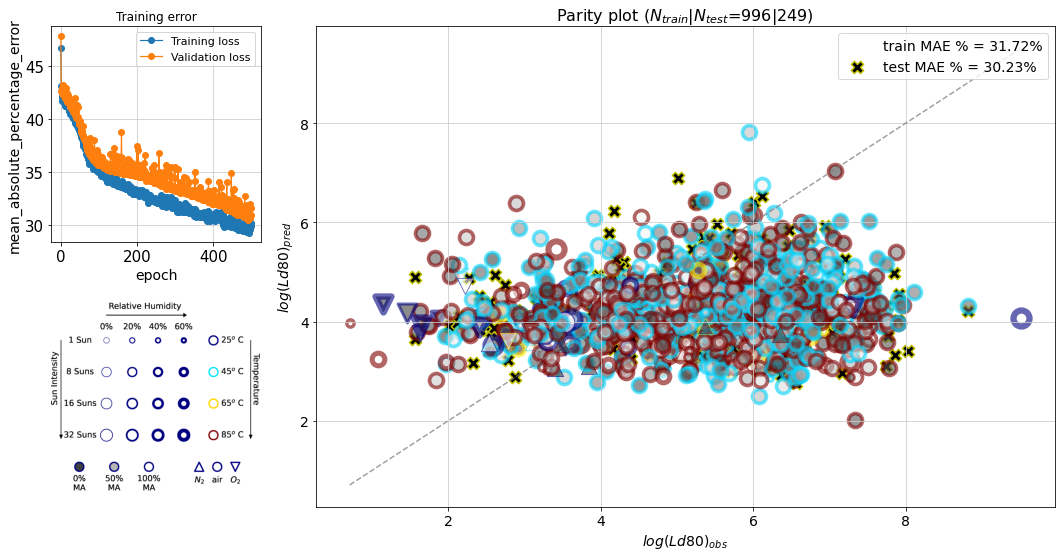

In [ ]:
#@title Parity Plot
history_csv = model.history_df
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

# The training and validation error vs epochs plot
model.fit_plot(ax[0, 0],)
ax[0,0].set_title("Training error", fontsize=12)

# The legend plot
model.parity_legend(ax[1, 0], dpi=300)

# Joining two axes to get a big figure for parity plot
gs = ax[0, 1].get_gridspec()
for a in ax[0:, 1:].flatten():
    a.remove()
big_ax = fig.add_subplot(gs[0:, 1:])
model.parity_plot(big_ax, y_train=y_train, y_test=y_test,
                  y_train_pred=y_train_pred, y_test_pred=y_test_pred,
                  data_df_train=data_df_train, data_df_test=data_df_test,
                  )
title_str = 'Parity plot ($N_{train}|N_{test}$'+'={}|{})'.format(len(y_train),
                                                                len(y_test))
big_ax.set_title(title_str, fontsize=16)
fig.tight_layout()


### **Optimizing the batch size for log(Ld80) prediction using CNN**

We have tested the model over different batch sizes to see which one gives the best results. Due to time constraints, we here present the saved models.

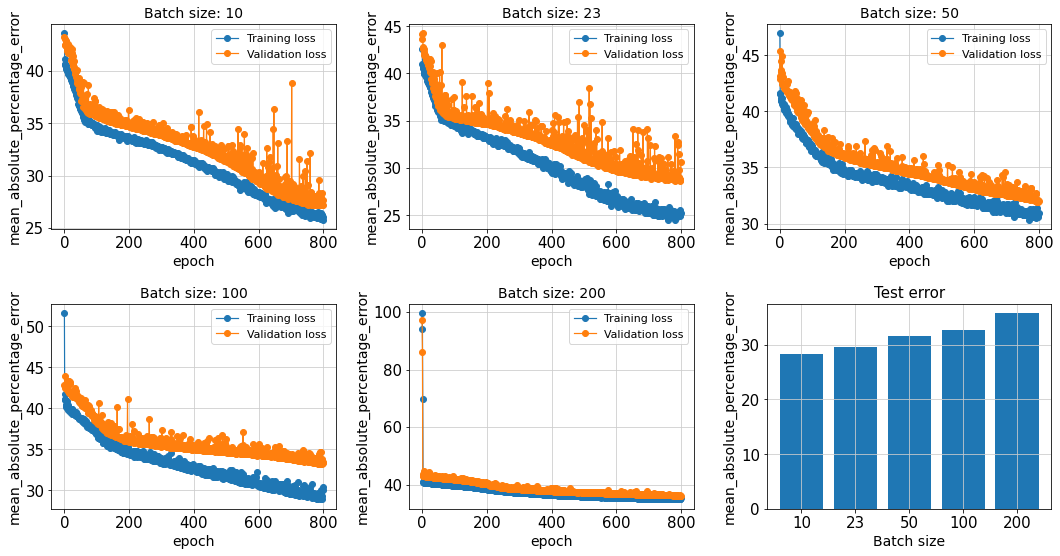

In [ ]:
#@title Loss vs Batch Size
batch_size_list = [10, 23, 50, 100, 200]
nrows, ncols = misc.best_rowcol_split(len(batch_size_list)+1)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
ax = ax.flatten()
test_errors_list = []

for i, batch_size in enumerate(batch_size_list):
    model_name = 'model_logs_batch'+str(batch_size)
    model = cnn.CNNPredictor(name=model_name, y_label=y_label)
    model.load_model(model_name, from_drive=True)
    model.fit_plot(ax[i])
    ax[i].set_title('Batch size: '+str(batch_size), fontsize=14)
    test_errors_list.append(model.evaluate_error(X_test, y_test))

ax[-1].bar(np.arange(len(batch_size_list)), test_errors_list,
           linewidth=1)
ax[-1].set_title('Test error', fontsize=15)
ax[-1].set_xticks(ticks=np.arange(len(batch_size_list)))
ax[-1].set_xticklabels(batch_size_list)
ax[-1].tick_params(axis='both', labelsize=15)
ax[-1].set_ylabel(model.loss_metric, fontsize=14)
ax[-1].set_xlabel('Batch size', fontsize=14)
fig.tight_layout()

### <font color='red'>The Convolutional neural network doesn't seem to do a great job</font>. This indicates that other features like the environmental conditions during degradation and other optoelectronic 1D features like diffusion length measurements etc,. must be augmented with the PL data to get a better prediction.

# Route - 2 : Encoding spatial information in PL images via Convolutional Autoencoder and sequential feed of the encoder output to a linear regression model.
___

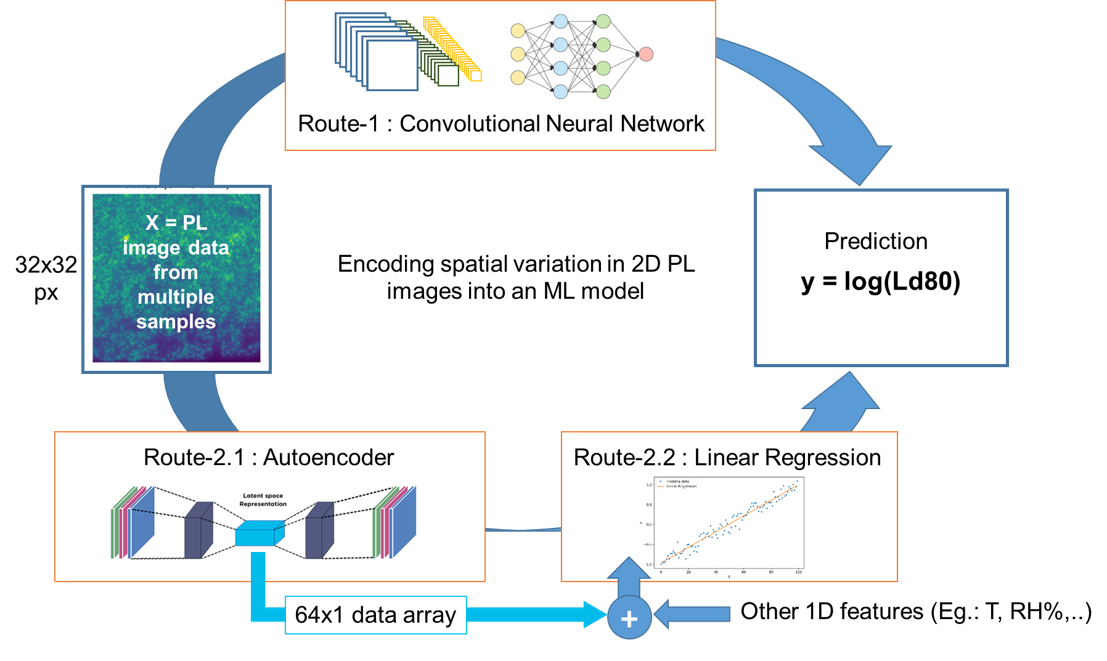

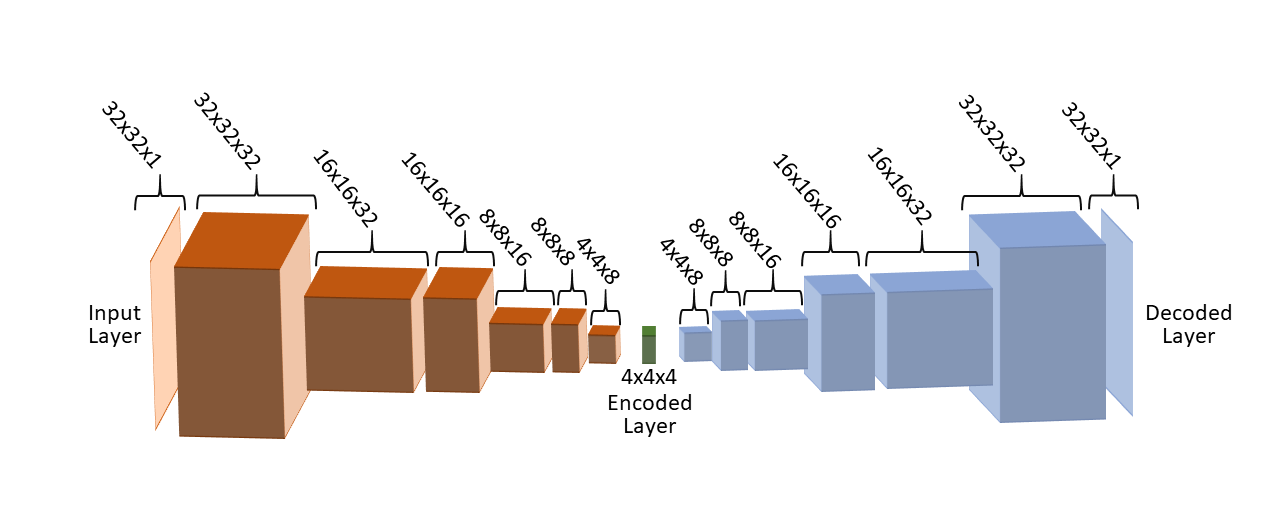

## **Visualization of Decoded/Encoded Layers**

Our autoencoder, which is trained with the initial images serving as the labels, was optimized and the resulting decoded and encoded layers are shown below.

In [ ]:
# Load dataset
dataset = loader.PLDataLoader()

# Create an instance of the autoencoder class
file_name = 'jasonlikespickles.h5'
ae = autoencoder(h5_name=file_name)

# Rescale dataset

X_train = dataset.X / dataset.X.max()

In [ ]:
decoder_shell, encoder_shell = ae.build_autoencoder()

decoder_path = '/content/drive/Shareddrives/Perovskites_DIRECT/models/autoencoder_model/jasonlikespickles.h5'
decoder_shell.load_weights(decoder_path)

encoder_path = '/content/drive/Shareddrives/Perovskites_DIRECT/models/encoder_model/jasonlikespickles.h5'
encoder_shell.load_weights(encoder_path)

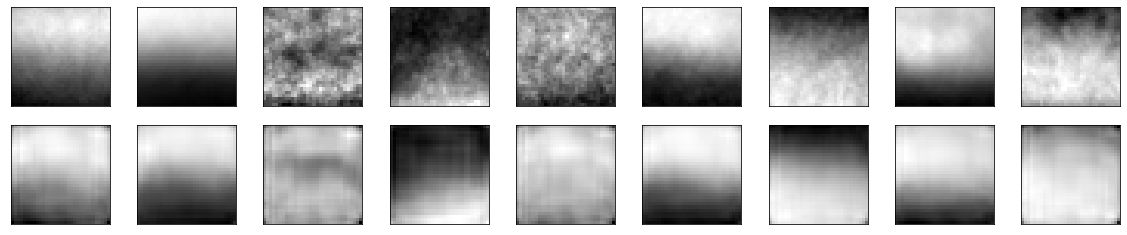

In [ ]:
#@title Autoencoder Results
decoded_imgs = decoder_shell.predict(X_train)
n = 9 
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_train[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
   

plt.show()

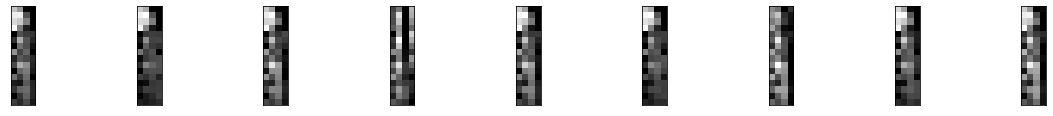

In [ ]:
#@title Encoder Visualization
encoded_imgs = encoder_shell.predict(X_train)
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(encoded_imgs[i].reshape(16,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### **Autoencoder wrapper function -PCA vs no PCA-**

As mentioned in the overview, now that we've optimized the autoencoder, we can go down one of two paths. Either running an additional PCA step or not. First, lets examine what we will return if we opt not to run PCA:

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0   

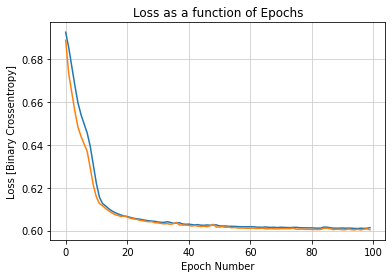

In [ ]:
autoencoder_outputs = ae.autoencoder_to_classification(epochs=100, run_PCA=False)

In [ ]:
#@title No PCA Cluster Matrix
print('Image Indecies:', len(autoencoder_outputs[0]))
print(autoencoder_outputs[0][0])
print('')
print('')

print('Encoded Matrix:', autoencoder_outputs[1].shape)
print(autoencoder_outputs[1][0])
print('')
print('')

print('Cluster Labels:', autoencoder_outputs[2].shape)
print(autoencoder_outputs[2][0])
print('')
print('')

print('Clusters:', autoencoder_outputs[3].shape)
print(autoencoder_outputs[3][0])


Image Indecies: 1245
drive/Shareddrives/Perovskites_DIRECT/Effort_Perovskites_3/200812_Gradients/PL_PC_T_MA70Cs30PI_MA85FA15PI_65C_40RH_air/primary_vids/PL_PC_T_MA70Cs30PI_MA85FA15PI_65C_40RH_air_grad0_loc18_time0/MMStack_Pos0.ome.tif


Encoded Matrix: (1245, 64)
[0.1578266  0.1850262  0.06109838 0.         0.09665914 0.2040442
 0.07165402 0.17219071 0.17370261 0.20647702 0.05073032 0.16695218
 0.1326824  0.07705437 0.10320196 0.1016277  0.40954953 0.33910894
 0.37440556 0.         0.3557591  0.39524776 0.3837614  0.18171693
 0.35254756 0.36958724 0.31499988 0.10065211 0.2425444  0.08535015
 0.2249475  0.14817786 0.48050424 0.45915198 0.24673307 0.
 0.49187878 0.48888567 0.2557018  0.15769899 0.51552427 0.48324326
 0.1786553  0.13788973 0.27142963 0.14877224 0.16259496 0.13435404
 0.27319193 0.0946511  0.37544498 0.08805966 0.39287204 0.12778898
 0.43014622 0.3712274  0.35930628 0.11255544 0.4577027  0.38566393
 0.09299584 0.         0.3325551  0.23120566]


Cluster Labels: (1245, 2)
[

However, as feeding our linear regression fewer, more highly-weighted features would be ideal, we also tried running pricipal component analysis on our encoded matrices. Yes, this is an exmaple of dimensionally reducing a dimensional reduction but hey... we're meta like that.

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0   

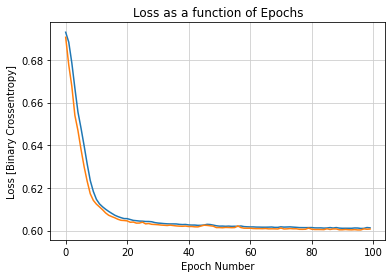

In [ ]:
autoencoder_outputs = ae.autoencoder_to_classification(epochs=100, run_PCA=True)

In [ ]:
#@title PCA Cluster Matrix
print('Image Indecies:', len(autoencoder_outputs[0]))
print(autoencoder_outputs[0][0])
print('')
print('')

print('Encoded Matrix:', autoencoder_outputs[1].shape)
print(autoencoder_outputs[1][0])
print('')
print('')

print('Cluster Labels:', autoencoder_outputs[2].shape)
print(autoencoder_outputs[2][0])
print('')
print('')

print('Clusters (PCA reduced):', autoencoder_outputs[3].shape)
print(autoencoder_outputs[3][0])
print('')
print('')

print('PCA encoded Matrix:', autoencoder_outputs[4].shape)
print(autoencoder_outputs[4][0])

Image Indecies: 1245
drive/Shareddrives/Perovskites_DIRECT/Effort_Perovskites_3/200812_Gradients/PL_PC_T_MA70Cs30PI_MA85FA15PI_65C_40RH_air/primary_vids/PL_PC_T_MA70Cs30PI_MA85FA15PI_65C_40RH_air_grad0_loc18_time0/MMStack_Pos0.ome.tif


Encoded Matrix: (1245, 64)
[0.01181949 0.4531323  0.11035793 0.43031347 0.03073055 0.265095
 0.         0.4153006  0.00758147 0.29676896 0.         0.41495407
 0.05668787 0.08305104 0.08798994 0.09517103 0.03028592 0.49482608
 0.13509944 0.4627104  0.         0.18922506 0.         0.41509888
 0.         0.25199118 0.         0.40992785 0.         0.02573743
 0.24849167 0.1345342  0.         0.46925694 0.13370131 0.5322818
 0.         0.19648673 0.         0.4544028  0.         0.2793414
 0.         0.47635287 0.         0.05951955 0.24372494 0.10936586
 0.04109234 0.7111337  0.28361827 0.43182027 0.         0.5414479
 0.         0.4919423  0.         0.638299   0.08661947 0.50880206
 0.10490935 0.18458019 0.27978536 0.25643325]


Cluster Labels: (1245, 

### **Autoencoder Cluster Visualization**



Using the above clusters, we selected 10 random initial images from each cluster and displayed them to see whether or not any distiguishable features were observed.

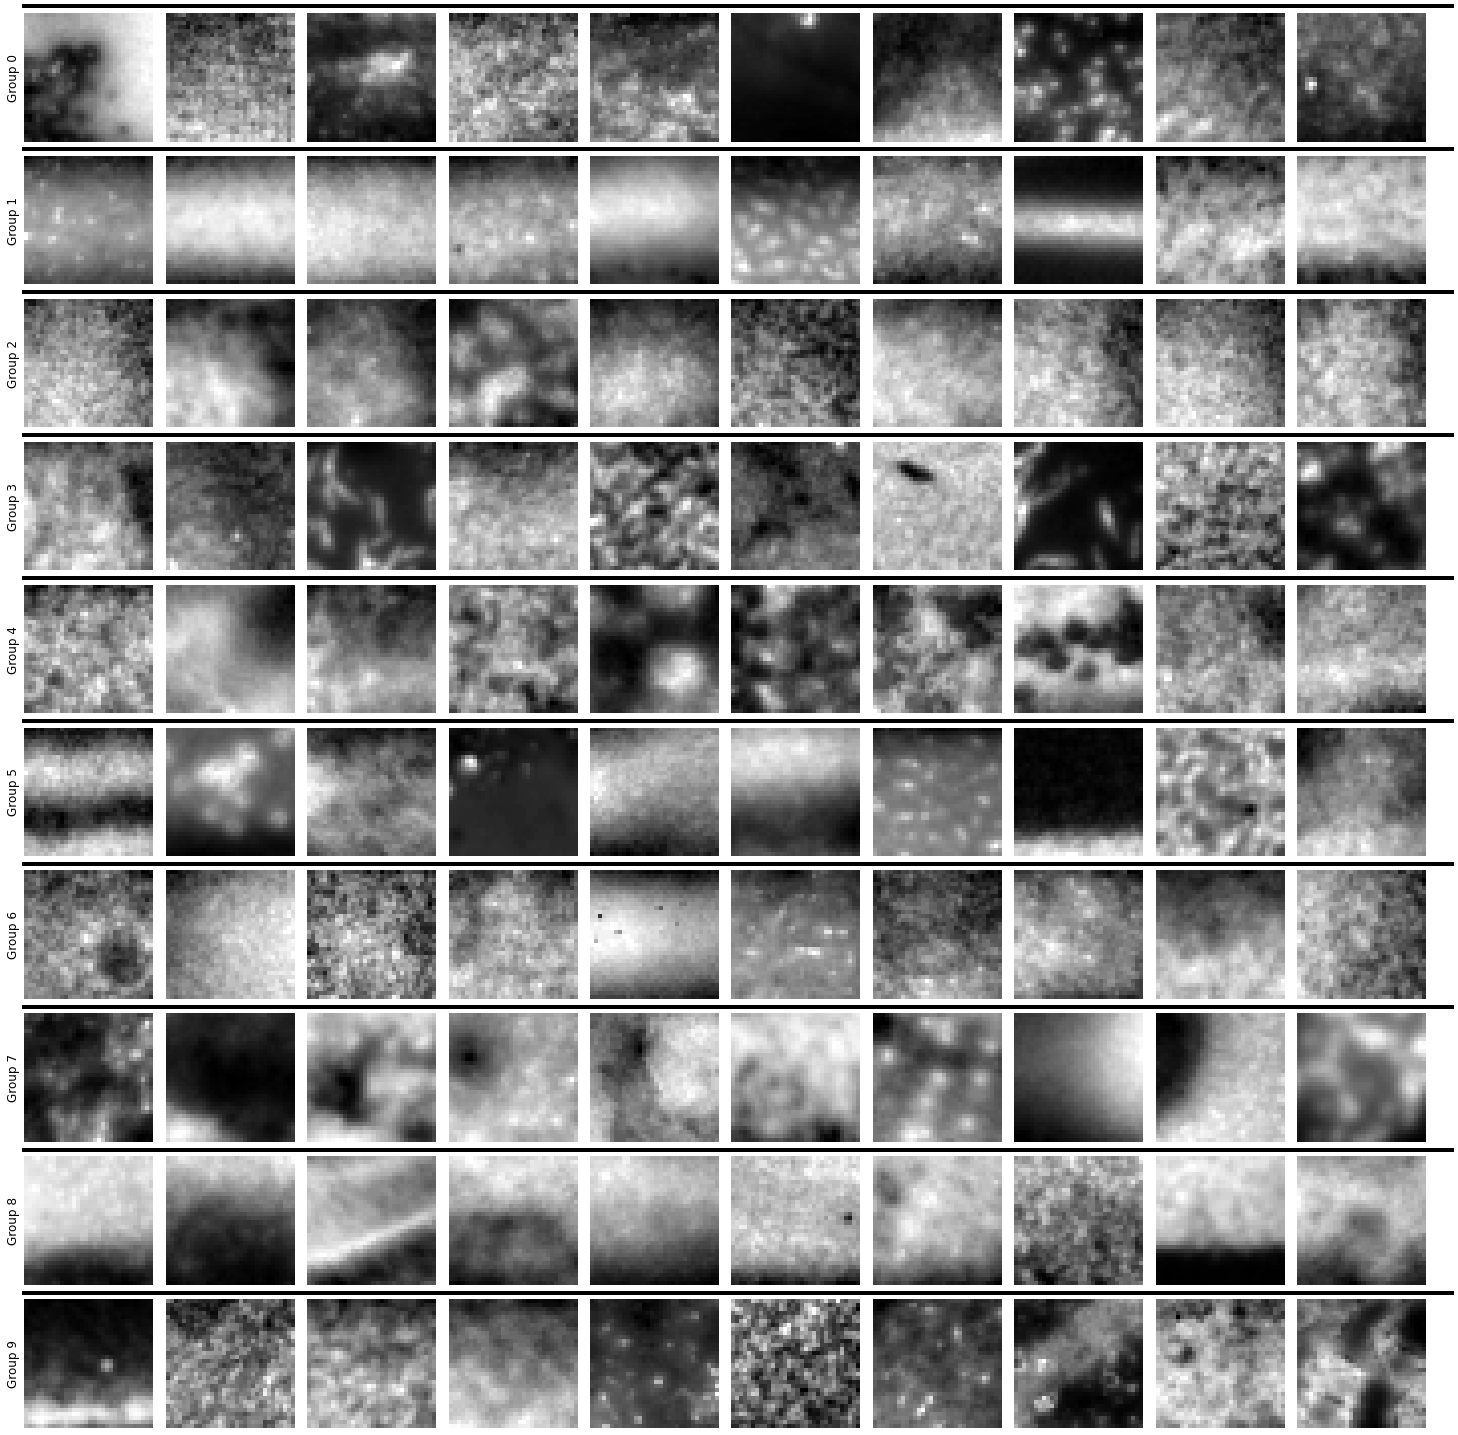

In [ ]:
ID_dict = assign_IDs(dataset, autoencoder_outputs[2])
visualize_clusters(ID_dict)

# Training and saving a Linear Regression model with just the 1D feaures, and no PL data
___

* ***Input row*** : 1D array with environmental conditions (like T, RH%, O2%) and early time measurements as features (Ld, PL and Tr measurements at t = 0, 5 etc.) 
* ***Output*** : log(Ld80) prediction values with shape (N,)

We developed a `linear_regression()` function that can take a `model_type` string to select the type of linear regression. For regularized models like Lasso and Ridge, it even uses cross-validation to tune the regularization
hyperparameter.

In [ ]:
#@title Training LinReg without Autoencoder Data
encoded_array, df_inds = autoencoder(dataset,
                                     h5_name='linreg_autoencoder'
                                    ).core_autoencoder_fxn()

# Train-test split of entire dataset
inds_train, inds_test = loader.train_test_split(np.arange(len(df_inds)),
                                         test_size=0.2, random_state=42)

df_inds_train = np.array(df_inds)[inds_train]
df_inds_test = np.array(df_inds)[inds_test]

data_df_train = dataset.data_df.loc[df_inds_train]
data_df_test = dataset.data_df.loc[df_inds_test]

# Make the X_train and X_test with autoencoder features
# appended to regular features.
X_train = np.c_[data_df_train.values[:, 1:], encoded_array[inds_train, :]]
y_train = data_df_train.values[:, 0]
X_test = np.c_[data_df_test.values[:, 1:], encoded_array[inds_test, :]]
y_test = data_df_test.values[:, 0]

# Apply log transform
y_train = np.log(y_train)
y_test = np.log(y_test)
y_label = 'log('+model_info['y_col']+'_in_min.)'
encoder_feat_labels = ['AE'+str(i) for i in range(encoded_array.shape[1])]
feat_labels = data_df_train.columns[1:].to_list() + encoder_feat_labels

print("Total number of features: ", X_train.shape[0])

In [ ]:
from sklearn.model_selection import train_test_split
model_name = 'training_demo'
linreg_dict = linreg.linear_regressor(X_train, y_train,
                                      X_test, y_test,
                                      feat_labels,
                                      y_label,
                                      model_type='Ridge',
                                      alpha_tuning_params={},
                                      model_folder=model_name,
                                      save_to_drive=True,
                                      overwrite_existing_model=True,
                                    )
model = linreg_dict['fit']
scaler = linreg_dict['scaler']

neg_mean_absolute_percentage_error  is not available in sklearn.metrics. Using
              'neg_mean_absolute_error' instead.

------------------------------------------
Regularization hyperparameter tuning by cv
------------------------------------------
alpha range        :  (1.00e-03, 1.00e-03)
No. of folds       :  5
Maximum iterations :  2
Tolerance          :  1.00e-02
Model type         :  Lasso
Scoring metric     :  neg_mean_absolute_error 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.7s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    5.7s finished


------------------------------------------
The best regularization alpha:  0.001
------------------------------------------

Fitting  Ridge  model on traning dataset...

Model saved as dict in  /content/drive/Shareddrives/Perovskites_DIRECT/models/linreg_saved_models/training_demo/fit_pickle.pickle


You can visualize the model using the functions in the `regression_visualization` module. Some functions have been used here for demonstration.
* `coefficient_bar_char()` function displays the top feature's coefficient with absolute values larger than a given tolerance value. The coeffients which are <font color="green"> **positive are colored green**</font> and those which are <font color="red">**negative are colored red**</font>.
* `parity_legend()` function displays the legend for parity plot's marker styling.
* `styled_parity_plot()` function plots the parity plot with the environmental features as marker style.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


This scoring metric is not available. Returning the
                  mean absolute percentage error instead...

This scoring metric is not available. Returning the
                  mean absolute percentage error instead...



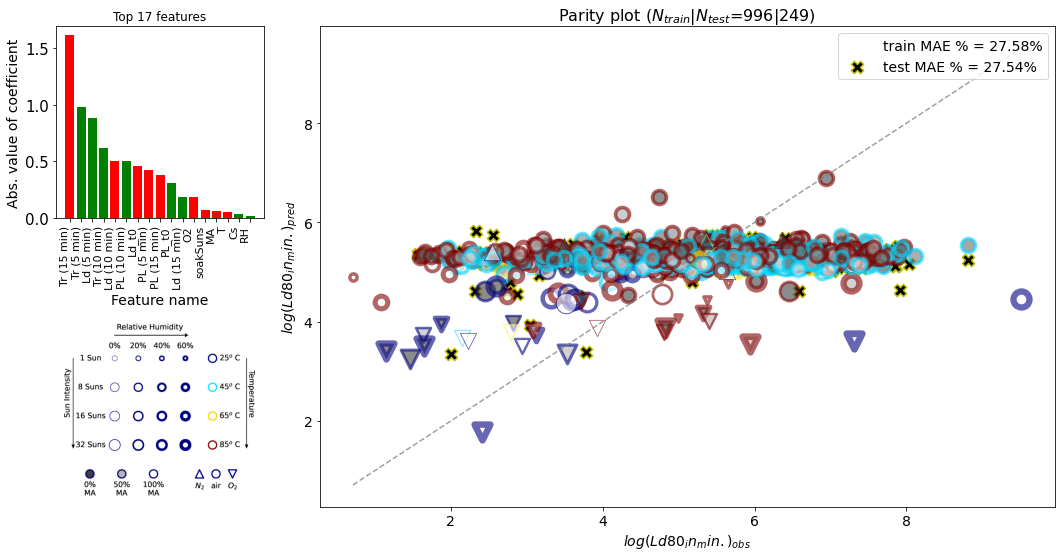

In [ ]:
#@title Parity plot of trained data without Autoencoder Data
y_train_pred = model.predict(scaler.transform(X_train))
y_test_pred = model.predict(scaler.transform(X_test))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

# The coefficients plot
_, _, top_feats = reg_vis.coefficient_bar_chart(ax[0, 0], feat_labels,
                                                model.coef_,
                                                tol=1e-2)
ax[0,0].set_title("Top {} features".format(len(top_feats)), fontsize=12)
ax[0, 0].grid(False)

# The legend plot
reg_vis.parity_legend(ax[1, 0], dpi=300)

# # Joining two axes to get a big figure for parity plot
gs = ax[0, 1].get_gridspec()
for a in ax[0:, 1:].flatten():
    a.remove()
big_ax = fig.add_subplot(gs[0:, 1:])
reg_vis.styled_parity_plot(big_ax, y_train=y_train, y_test=y_test,
                           y_train_pred=y_train_pred, y_test_pred=y_test_pred,
                           data_df_train=data_df_train,
                           data_df_test=data_df_test,
                           y_label=y_label
                           )
title_str = 'Parity plot ($N_{train}|N_{test}$'+'={}|{})'.format(len(y_train),
                                                                len(y_test))
big_ax.set_title(title_str, fontsize=16)
big_ax.grid(False)
fig.tight_layout()

The `model_folder` arguement in the `linear_regressor()` function saves the model as a pickle file in `linreg_saved_models` folder with the name in `<model_folder>`. 

In [ ]:
saved_models_path = model_info['linreg_model_info']['models_folder_path']
saved_models_path = model_info['shared_drive_path'] + '/' + saved_models_path
curr_model_path = saved_models_path + '/' + model_name

print("In linreg_saved_models folder in the shared drive:")
!ls $saved_models_path
print("\nIn '"+ model_name+"' folder in the cnn_saved_models:")
!ls $curr_model_path

In linreg_saved_models folder in the shared drive:
training_demo  training_demo_autoencoder

In 'training_demo' folder in the cnn_saved_models:
fit_pickle.pickle


### Till now, we haven't incorporated the PL image data into the linear regression model. Let's do that now.

### **Modification: Feeding PL image features into the Linear regression model using an autoencoder's output**

Now, to incorporate the PL image data into the linear regression model, we used an autoencoder to encode 2D image data into 1D arrays each of length 64. First, the autoencoder is run on the entire dataset using the method `core_autoencoder_fxn()` of the `autoencoder` class in the `autoencode_to_encoder` module. This returns the total dataset's encoded arrays and their corresponding indices in the master dataframe.


In [ ]:
encoded_array, df_inds = autoencoder(dataset,
                                     h5_name='linreg_autoencoder'
                                    ).core_autoencoder_fxn()

Make the train-test splits and augment the autoencoder data from the PL images, to the experimental features data.

In [ ]:
#@title Training LinReg with Autoencoder Data
encoded_array, df_inds = autoencoder(dataset,
                                     h5_name='linreg_autoencoder'
                                    ).core_autoencoder_fxn()

# Train-test split of entire dataset
inds_train, inds_test = loader.train_test_split(np.arange(len(df_inds)),
                                         test_size=0.2, random_state=42)

df_inds_train = np.array(df_inds)[inds_train]
df_inds_test = np.array(df_inds)[inds_test]

data_df_train = dataset.data_df.loc[df_inds_train]
data_df_test = dataset.data_df.loc[df_inds_test]

# Make the X_train and X_test with autoencoder features
# appended to regular features.
X_train = np.c_[data_df_train.values[:, 1:], encoded_array[inds_train, :]]
y_train = data_df_train.values[:, 0]
X_test = np.c_[data_df_test.values[:, 1:], encoded_array[inds_test, :]]
y_test = data_df_test.values[:, 0]

# Apply log transform
y_train = np.log(y_train)
y_test = np.log(y_test)
y_label = 'log('+model_info['y_col']+'_in_min.)'
encoder_feat_labels = ['AE'+str(i) for i in range(encoded_array.shape[1])]
feat_labels = data_df_train.columns[1:].to_list() + encoder_feat_labels

print("Total number of features: ", X_train.shape[0])

So, the new model is -
* ***Input row*** : 1D array with environmental conditions (like T, RH%, O2%) and early time measurements as features (Ld, PL and Tr measurements at t = 0, 5 etc.) + ***PL features obtained from the Autoencoder***
* ***Output*** : log(Ld80) prediction values with shape (N,)

In [ ]:
model_name = 'training_demo_autoencoder'
ae_linreg_dict = linreg.linear_regressor(X_train, y_train,
                                        X_test, y_test,
                                        feat_labels,
                                        y_label,
                                        model_type='Ridge',
                                        alpha_tuning_params=dict(
                                            alpha_list=[1e-5,1e1],
                                        ),
                                        model_folder=model_name,
                                        save_to_drive=True,
                                        overwrite_existing_model=True,
                                        )
model = ae_linreg_dict['fit']
scaler = ae_linreg_dict['scaler']

neg_mean_absolute_percentage_error  is not available in sklearn.metrics. Using
              'neg_mean_absolute_error' instead.

------------------------------------------
Regularization hyperparameter tuning by cv
------------------------------------------
alpha range        :  (1.00e-05, 1.00e-05)
No. of folds       :  5
Maximum iterations :  2
Tolerance          :  1.00e-02
Model type         :  Lasso
Scoring metric     :  neg_mean_absolute_error 

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    7.7s finished


------------------------------------------
The best regularization alpha:  1e-05
------------------------------------------

Fitting  Ridge  model on traning dataset...

Model saved as dict in  /content/drive/Shareddrives/Perovskites_DIRECT/models/linreg_saved_models/training_demo_autoencoder/fit_pickle.pickle


Visualizing the model using the parity plot and the coefficient plot.

This scoring metric is not available. Returning the
                  mean absolute percentage error instead...

This scoring metric is not available. Returning the
                  mean absolute percentage error instead...



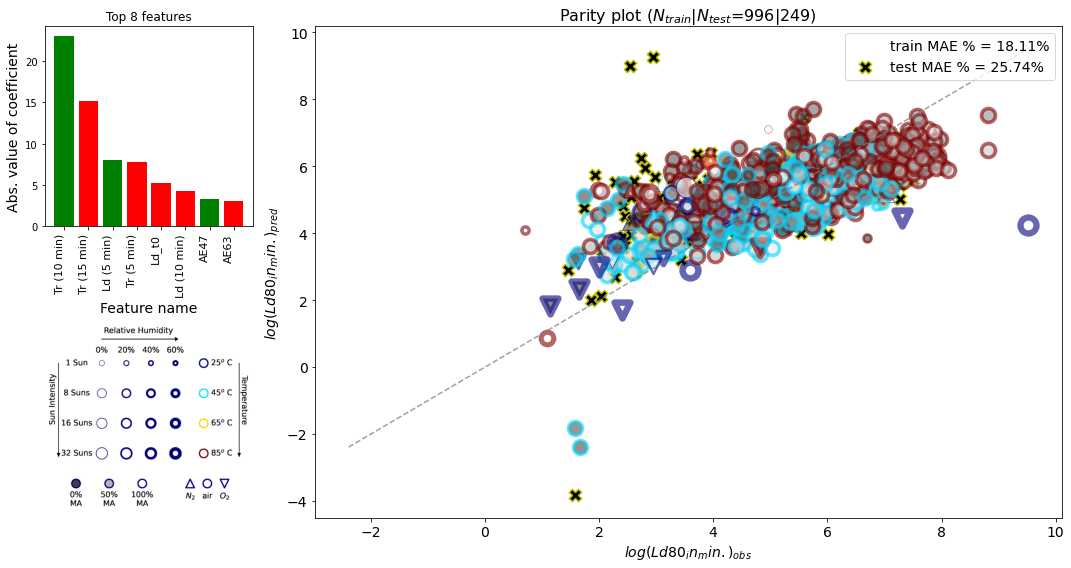

In [ ]:
#@title Parity plot of trained data with Autoencoder Data
y_train_pred = model.predict(scaler.transform(X_train))
y_test_pred = model.predict(scaler.transform(X_test))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

# The coefficients plot
_, _, top_feats = reg_vis.coefficient_bar_chart(ax[0, 0], feat_labels, model.coef_,
                              tol=3)
ax[0,0].set_title("Top {} features".format(len(top_feats)), fontsize=12)
ax[0, 0].grid(False)

# The legend plot
reg_vis.parity_legend(ax[1, 0], dpi=300)

# # Joining two axes to get a big figure for parity plot
gs = ax[0, 1].get_gridspec()
for a in ax[0:, 1:].flatten():
    a.remove()
big_ax = fig.add_subplot(gs[0:, 1:])
reg_vis.styled_parity_plot(big_ax, y_train=y_train, y_test=y_test,
                           y_train_pred=y_train_pred, y_test_pred=y_test_pred,
                           data_df_train=data_df_train,
                           data_df_test=data_df_test,
                           y_label=y_label
                           )
title_str = 'Parity plot ($N_{train}|N_{test}$'+'={}|{})'.format(len(y_train),
                                                                len(y_test))
big_ax.set_title(title_str, fontsize=16)
big_ax.grid(False)
fig.tight_layout()


Autoencoder features show up in the top list of features and effectively encode the variance in the log(Ld80) values. This gives hope that initial time PL images effectively encode the sample-to-sample variation, which cannot be captured by the environmental features.

# Conclusion
___

### **Model Optimization**

![hyperparams](https://drive.google.com/uc?export=view&id=1FSp-ANyyfCQWQSD7Ou7Dmyuth8VEnDuy)

### **Project Struggles**
----
* ### Data Pipeline
* ### Testing Integration
![Travis CI & Google](https://drive.google.com/uc?export=view&id=1hbjVZvLDd9l9GNLSH4ihtEWeYlsQG7y6)





### **Next Steps**
-----

* ### Data Integration

  - **Hyak**
  - [![Coverage Status](https://coveralls.io/repos/github/afarley9/perovskites/badge.svg?branch=main)](https://coveralls.io/github/afarley9/perovskites?branch=main)
  - More data

* ### User-friendly Code

  - Generalize classes/functions
  - Readable
  - `setup.py`

    ![Programming Style](https://drive.google.com/uc?export=view&id=1o3mpiurKzSAidh7cwy2S1jeuJsctNI-6)

# **THANK YOU!**